In [140]:
%pylab inline
import os,sys,pickle
from scipy.stats import percentileofscore, chi2
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d
from scipy.special import loggamma, gamma as gamma_fn
from scipy.optimize import minimize

Populating the interactive namespace from numpy and matplotlib


/usr/licensed/anaconda3/2020.7/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['diff']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Even-Parity BOSS 4PCF Analysis
This notebook contains the main analysis routines used in Philcox++ (2021) to probe non-Gaussianity in the BOSS 4-point correlation functions.

In [141]:
# Data directories
indirN = '/projects/QUIJOTE/Oliver/npcf/boss_4pcfN_production2/'
indir_disconN = '/projects/QUIJOTE/Oliver/npcf/boss_4pcfN_production2/'#production_disc/'

indirS = '/projects/QUIJOTE/Oliver/npcf/boss_4pcfS_production2/'#production/'
indir_disconS = '/projects/QUIJOTE/Oliver/npcf/boss_4pcfS_production2/'#production_disc/'

plot_dir = '/home/ophilcox/Parity-Even-4PCF/figs/'
if not os.path.exists(plot_dir): os.makedirs(plot_dir)

# Binning parameters
R_min = 20
R_max = 160
n_r = 10

# If False, turn off blinding
fake_data = True

# 1) Load 4PCFs
- These are computed with the [*encore*](https://github.com/oliverphilcox/encore) code of [Philcox et al. 2021](https://arxiv.org/abs/2105.08722)
- We use 10 linearly-spaced radial bins in the range [20, 160] $h^{-1}\mathrm{Mpc}$
- Multiplets are computed up to $\ell_\mathrm{max} = 5$, with $\ell=5$ multiplets only being used for edge-correction.
- Here we consider only bins with $\ell_i\leq 4$ to keep the dimensionality reasonable.
- We analyze both the BOSS data, in the CMASS NGC and SGC regions, as well as 250 MultiDark-Patchy mocks.

In [142]:
binner = lambda bins: (0.5+bins)*(R_max-R_min)/n_r+R_min

def load_patchy(indir,return_all=False,discon=False):
    """Load 4PCFs from Patchy"""
    all_fourpcf = []
    for sim_no in range(1,1001):
        if discon:
            infile = indir+'patchy%d_cmass.zeta_discon_4pcf.txt'%sim_no
        else:
            infile = indir+'patchy%d_cmass.zeta_4pcf.txt'%sim_no
        if not os.path.exists(infile): continue
        bins1,bins2,bins3 = np.asarray(np.loadtxt(infile,skiprows=3,max_rows=3),dtype=int)
        ell1,ell2,ell3 = np.asarray(np.loadtxt(infile,skiprows=9)[:,:3],dtype=int).T
        indat = np.loadtxt(infile,skiprows=9)[:,3:]
        all_fourpcf.append(indat)
        if sim_no==1:
            r1_4pcf = binner(bins1)
            r2_4pcf = binner(bins2)
            r3_4pcf = binner(bins3)  
    if return_all:
        return [r1_4pcf,r2_4pcf,r3_4pcf],[bins1,bins2,bins3],[ell1,ell2,ell3],all_fourpcf
    else:
        return all_fourpcf

In [143]:
# # Load Patchy data
# radii, bins, ells, fourpcfNall = load_patchy(indirN,return_all=True)
# fourpcfSall = load_patchy(indirS)  

# # Remove any odd multipoles!
# odds = np.asarray([(-1)**(ells[0][i]+ells[1][i]+ells[2][i])==-1 for i in range(len(fourpcfSall[0]))])
# fourpcfSall = np.asarray(fourpcfSall)[:,~odds]
# fourpcfNall = np.asarray(fourpcfNall)[:,~odds]

# # Load Patchy disconnected data
# radii, bins, ells, fourpcfNdisc = load_patchy(indir_disconN,discon=True,return_all=True)
# fourpcfSdisc = load_patchy(indir_disconS,discon=True)

# np.savez('/home/ophilcox/all_patchy_fourpcf.npz',fourpcfSall=fourpcfSall,fourpcfNall=fourpcfNall,
#         radii=radii,bins=bins,ells=ells,fourpcfSdisc=fourpcfSdisc,fourpcfNdisc=fourpcfNdisc)

with np.load('/home/ophilcox/all_patchy_fourpcf.npz') as d:
    fourpcfSall=d['fourpcfSall']
    fourpcfNall=d['fourpcfNall']
    radii=d['radii']
    bins=d['bins']
    ells=d['ells']
    fourpcfSdisc=d['fourpcfSdisc']
    fourpcfNdisc=d['fourpcfNdisc']

def load_boss(indir,discon=False):
    """Load 4PCFs from BOSS"""
    if discon:
        infile = indir+'boss_cmass.zeta_discon_4pcf.txt'
    else:
        infile = indir+'boss_cmass.zeta_4pcf.txt'
    indat = np.loadtxt(infile,skiprows=9)[:,3:]
    fourpcf_boss = indat
    return fourpcf_boss

# Compute connected only estimator
fourpcfN = np.asarray(fourpcfNall) - np.asarray(fourpcfNdisc)
fourpcfS = np.asarray(fourpcfSall) - np.asarray(fourpcfSdisc)

# Load Patchy disconnected data
n_radial = len(bins[0])
n_mult = len(ells[0])

# Load BOSS data
if fake_data:
    print("Replacing BOSS data with first Patchy mock")
    fourpcf_bossN = fourpcfN[0]
    fourpcf_bossS = fourpcfS[0]
    fourpcfN = fourpcfN.copy()[1:]
    fourpcfS = fourpcfS.copy()[1:]
else:
    fourpcf_bossNall = load_boss(indirN)
    fourpcf_bossSall = load_boss(indirS)
    fourpcf_bossNdisc = load_boss(indir_disconN,discon=True)
    fourpcf_bossSdisc = load_boss(indir_disconS,discon=True)
    
    fourpcf_bossN = np.asarray(fourpcf_bossNall) - np.asarray(fourpcf_bossNdisc)
    fourpcf_bossS = np.asarray(fourpcf_bossSall) - np.asarray(fourpcf_bossSdisc)
    
print("REMOVING MEAN")
meanN = np.mean(fourpcfN,axis=0)
meanS = np.mean(fourpcfS,axis=0)
for i in range(len(fourpcfN)):
    fourpcfN[i] = fourpcfN[i]+meanN*2
    fourpcfS[i] = fourpcfS[i]+meanS*2
fourpcf_bossN = fourpcf_bossN+meanN*2
fourpcf_bossS = fourpcf_bossS+meanS*2
    
n_mocks = len(fourpcfN)
assert n_mocks == len(fourpcfS)

print("N_mocks: %d"%n_mocks)
print("N_Lambda: %d"%n_mult)
print("N_radial: %d"%n_radial)

Replacing BOSS data with first Patchy mock
REMOVING MEAN
N_mocks: 999
N_Lambda: 69
N_radial: 120


# 2) Apply Data Cuts

- Apply the cuts described above for the radial and angular bins.

# TRY WITH RADIAL BINNING CONSTRAINT?

In [144]:
# filter out ells which are not properly edge-corrected
LMAX=4
ang_filt = np.asarray(np.logical_and(np.logical_and(ells[0]<=LMAX,ells[1]<=LMAX),ells[2]<=LMAX))

# optionally remove any bins within 14 Mpc of each other
dr = (R_max-R_min)/n_r
radial_filt = ((radii[1]-radii[0])>1.9*n_r)&((radii[2]-radii[1])>1.9*n_r)
print("Removing radial binning constraint!")
radial_filt = np.ones_like(radial_filt)

# Apply filters
filt_fourpcfN = np.asarray([ff[ang_filt][:,radial_filt] for ff in fourpcfN])
filt_fourpcfS = np.asarray([ff[ang_filt][:,radial_filt] for ff in fourpcfS])
filt_fourpcf_bossN = fourpcf_bossN[ang_filt][:,radial_filt]
filt_fourpcf_bossS = fourpcf_bossS[ang_filt][:,radial_filt]
filt_flat_fourpcfN = np.asarray([ff.ravel() for ff in filt_fourpcfN])
filt_flat_fourpcfS = np.asarray([ff.ravel() for ff in filt_fourpcfS])
filt_flat_fourpcf_bossN = filt_fourpcf_bossN.ravel()
filt_flat_fourpcf_bossS = filt_fourpcf_bossS.ravel()

# Redefine array dimensions
n_radial = np.sum(radial_filt)
n_mult = np.sum(ang_filt)

print("N_Lambda: %d"%n_mult)
print("N_bins: %d"%n_radial)
print("N_total: %d"%(n_mult*n_radial))

Removing radial binning constraint!
N_Lambda: 42
N_bins: 120
N_total: 5040


# 3) Plot Correlation and Covariance Matrices
- Theory covariances are computed in the Gaussian Random Field approximation as in Hou et al. (in prep.).
- Note that they do not include redshift-space distortions, non-Gaussian contributions, or a proper treatment of the survey geometry.
- For this reason they are used only as approximate tools for the compressed-Gaussian analyses below; importantly, we do *not* assume them to be equal to the true covariance of the data.

In [145]:
### Compute Patchy covariances
print("Computing Patchy covariances")
corrN = np.corrcoef(filt_flat_fourpcfN.T)
covN = np.cov(filt_flat_fourpcfN.T)
corrS = np.corrcoef(filt_flat_fourpcfS.T)
covS = np.cov(filt_flat_fourpcfS.T)

Computing Patchy covariances


In [146]:
# np.savez('/home/ophilcox/patchy_cov999.npz',ngc_cov=covN,sgc_cov=covS)

In [147]:
# ### Load theory covariances
# def load_theory_cov(patch):
#     if patch=='ngc':
#         cov_file = '/projects/QUIJOTE/Oliver/npcf/gaussian_cov/4pcf_patchy_ngc_even_nbar3.19E-4_z0d57_10rbins_expm2_dampSN_connected_all.cov.py2'
#     elif patch=='sgc':
#         cov_file = '/projects/QUIJOTE/Oliver/npcf/gaussian_cov/4pcf_patchy_sgc_even_nbar3.16E-4_z0d57_10rbins_expm2_dampSN_connected_all.cov.py2'
#     cov_dat = pickle.load(open(cov_file, "rb"))

#     # Construct covariance
#     theory_cov = np.zeros((n_mult*n_radial,n_mult*n_radial))
#     for i in range(n_mult):
#         lam1 = '%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i])
#         for j in range(n_mult):
#             lam2 = '%d%d%d'%(ells[0][ang_filt][j],ells[1][ang_filt][j],ells[2][ang_filt][j])
#             try: 
#                 this_cov = cov_dat[lam1,lam2]
#             except KeyError:
#                 try:
#                     this_cov = cov_dat[lam2,lam1].T
#                 except KeyError:
#                     print("Covariance element %s,%s has not been computed!"%(lam1,lam2))
#             theory_cov[i*n_radial:(i+1)*n_radial,j*n_radial:(j+1)*n_radial] = this_cov[radial_filt][:,radial_filt]
#     return theory_cov

# print("Loading theory covariances")
# theory_covN = load_theory_cov('ngc')
# theory_covS = load_theory_cov('sgc')

# theory_corrN = theory_covN/np.sqrt(np.outer(np.diag(theory_covN),np.diag(theory_covN)))
# theory_corrS = theory_covS/np.sqrt(np.outer(np.diag(theory_covS),np.diag(theory_covS)))

# # Invert the theory covariance
# print("Computing inverse theory covariances")
# inv_theory_covN = np.linalg.inv(theory_covN)
# inv_theory_covS = np.linalg.inv(theory_covS)

# # Define the eigenvectors from the inverse theory covariance
# print("Performing eigendecomposition")
# evalsN,evecsN = np.linalg.eigh(inv_theory_covN)
# evalsS,evecsS = np.linalg.eigh(inv_theory_covS)

# np.savez('/home/ophilcox/even_data.npz',evalsN=evalsN,evalsS=evalsS,evecsN=evecsN,evecsS=evecsS,
#         inv_theory_covN=inv_theory_covN,inv_theory_covS=inv_theory_covS,
#         theory_covN=theory_covN,theory_covS=theory_covS,theory_corrN=theory_corrN,theory_corrS=theory_corrS)

In [148]:
with np.load('/home/ophilcox/even_data.npz') as d:
    evalsN = d['evalsN']
    evalsS = d['evalsS']
    evecsN = d['evecsN']
    evecsS = d['evecsS']
    inv_theory_covN = d['inv_theory_covN']
    inv_theory_covS = d['inv_theory_covS']
    theory_covN = d['theory_covN']
    theory_covS = d['theory_covS']
    theory_corrN = d['theory_corrN']
    theory_corrS = d['theory_corrS']

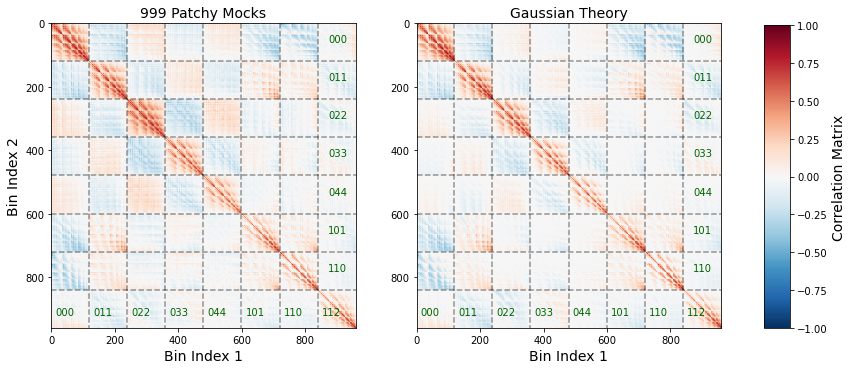

In [149]:
n_max = 8
fig,ax = plt.subplots(1,2,figsize=(12,6))
im = ax[0].imshow(corrN[:n_max*n_radial,:n_max*n_radial],vmax=1,vmin=-1,cmap=cm.RdBu_r);
im = ax[1].imshow(theory_corrN[:n_max*n_radial,:n_max*n_radial],vmax=1,vmin=-1,cmap=cm.RdBu_r);
#im.colorbar();
for i in range(n_max):
    for a in range(2):
        if i!=0: ax[a].hlines(n_radial*i-1,0,n_max*n_radial,linestyles='--',alpha=0.4)
        if i!=0: ax[a].vlines(n_radial*i-1,0,n_max*n_radial,linestyles='--',alpha=0.4)
        if i!=n_max-1: ax[a].text(n_radial*(n_max-1)+n_radial/10+20,n_radial*i+n_radial/2,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10)
        ax[a].text(n_radial*i+n_radial/10,n_radial*(n_max-1)+n_radial/2+20,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10)
for a in range(2):
    ax[a].set_xlim([0,n_radial*n_max-1])
    ax[a].set_ylim([n_radial*n_max-1,0])
ax[0].set_title('%d Patchy Mocks'%n_mocks,fontsize=14)
ax[1].set_title('Gaussian Theory',fontsize=14);
for a in range(2): ax[a].set_xlabel(r'Bin Index 1',fontsize=14)
ax[0].set_ylabel(r'Bin Index 2',fontsize=14)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Correlation Matrix',fontsize=14)

fig.savefig(plot_dir+'correlation_comparison_ngc.pdf',bbox_inches='tight')

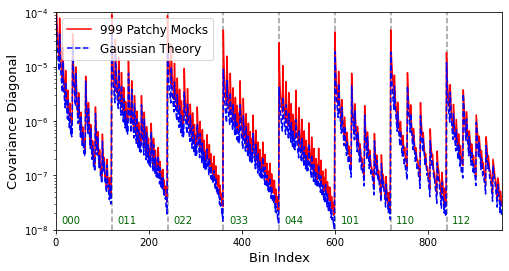

In [150]:
plt.figure(figsize=(8,4))
n_max = 8
plt.plot(np.diag(covN)[:n_max*n_radial],c='r',ls='-',label='%d Patchy Mocks'%n_mocks)
plt.plot(np.diag(theory_covN)[:n_max*n_radial],c='b',ls='--',label='Gaussian Theory')
plt.yscale('log')
plt.xlim([0,n_max*n_radial])
ylims = [1e-8,1e-4]
plt.ylim(ylims)
for i in range(n_max):
    if i!=0: plt.vlines(n_radial*i,ylims[0],ylims[1],linestyles='--',alpha=0.4)
    plt.text(n_radial*i+n_radial/10,ylims[0]*1.3,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10) 
plt.legend(loc='upper left',fontsize=12)
plt.xlabel(r'Bin Index',fontsize=13)
plt.ylabel(r'Covariance Diagonal',fontsize=13)

plt.savefig(plot_dir+'variance_comparison_ngc.pdf',bbox_inches='tight')

Text(0.5, 0, 'Bin Index')

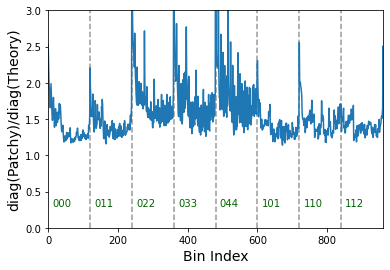

In [151]:
plt.plot(np.diag(covN)/np.diag(theory_covN))
plt.ylabel(r'diag(Patchy)/diag(Theory)',fontsize=14)
plt.xlim([0,n_max*n_radial])
plt.ylim([0,3])
for i in range(n_max):
    if i!=0: plt.vlines(n_radial*i,0,4,linestyles='--',alpha=0.4)
    plt.text(n_radial*i+n_radial/10,0.3,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10) 
plt.xlabel(r'Bin Index',fontsize=14)

In [152]:
print("SGC covariance is inflated relative to NGC by a factor of %.2f"%(np.mean(theory_covS/theory_covN)))

SGC covariance is inflated relative to NGC by a factor of 2.49


# 4) Plot Data
- We plot a selection of 4PCF multiplets below, since the total number is large. The eventual analysis makes use of all even-parity multiplets given the above restrictions.

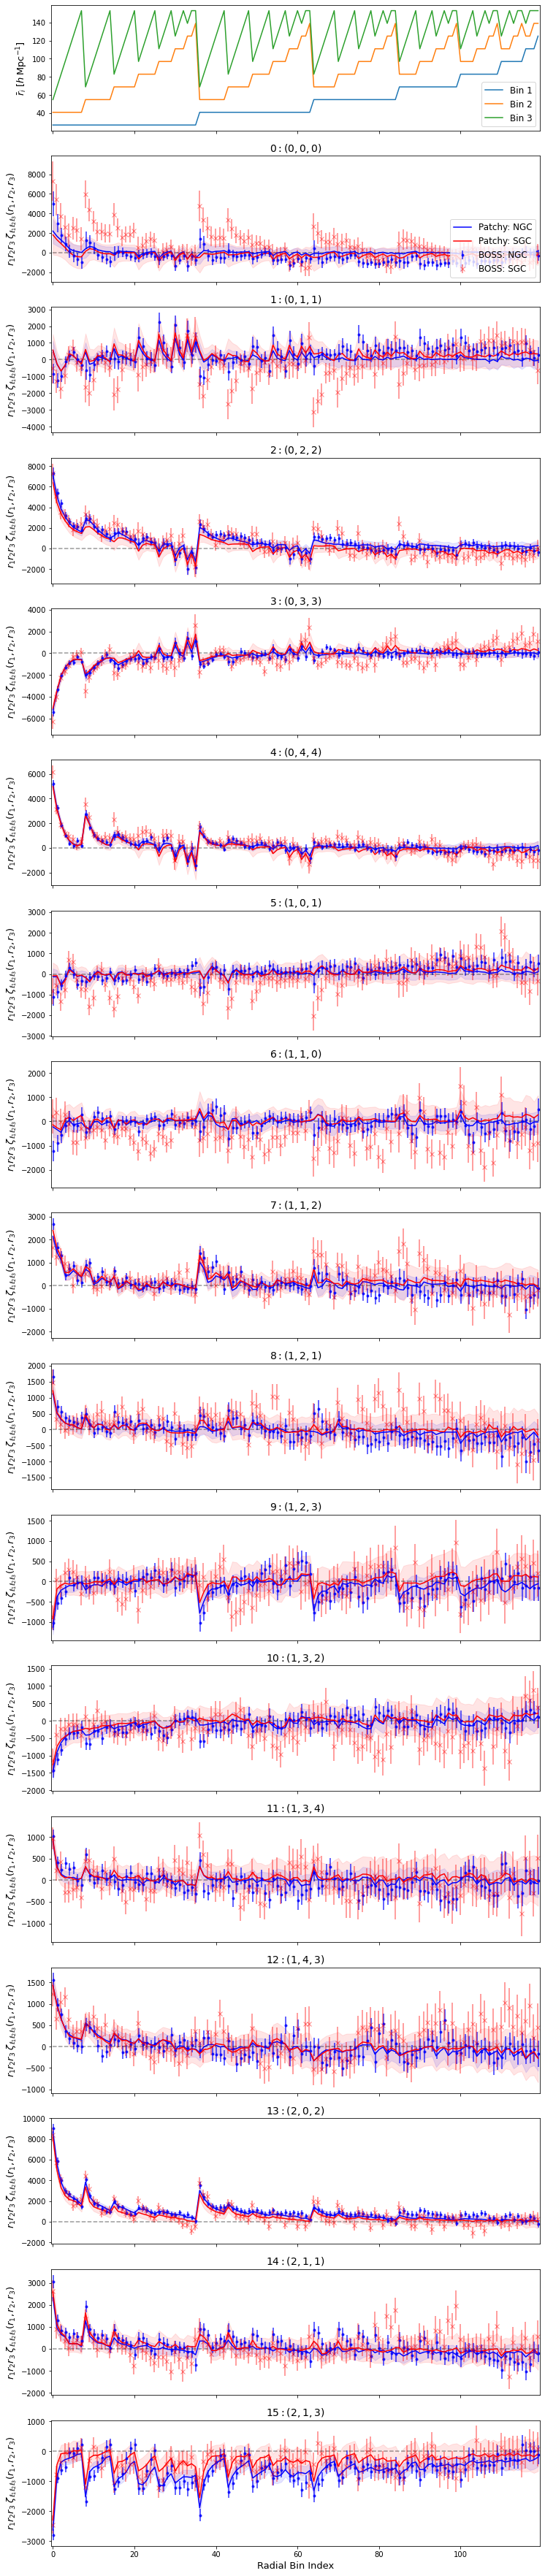

In [153]:
xmax = n_radial-1
r123 = (radii[0]*radii[1]*radii[2])[radial_filt]

which_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
n_plots = len(which_indices)

fig,ax = plt.subplots(n_plots+1,figsize=(12,4*n_plots),sharex=True)
ax[0].plot(np.arange(n_radial),radii[0][radial_filt],label='Bin 1')
ax[0].plot(np.arange(n_radial),radii[1][radial_filt],label='Bin 2')
ax[0].plot(np.arange(n_radial),radii[2][radial_filt],label='Bin 3')
ax[0].set_xlim([-0.5,xmax+0.5])
ax[0].set_ylabel(r'$\bar r_i$ [$h\,\mathrm{Mpc}^{-1}$]',fontsize=13)
ax[0].legend(loc='lower right',fontsize=12)

fourpcfN_mean = np.mean(filt_fourpcfN,axis=0)
fourpcfN_std = np.std(filt_fourpcfN,axis=0)#/np.sqrt(n_mocks)
fourpcfS_mean = np.mean(filt_fourpcfS,axis=0)
fourpcfS_std = np.std(filt_fourpcfS,axis=0)#/np.sqrt(n_mocks)

for ii,i in enumerate(which_indices):
    
    # Plot Patchy data
    ax[ii+1].fill_between(np.arange(n_radial),r123*(fourpcfN_mean[i]-fourpcfN_std[i]),
                     r123*(fourpcfN_mean[i]+fourpcfN_std[i]),color='b',alpha=0.1)
    ax[ii+1].plot(np.arange(n_radial),r123*fourpcfN_mean[i],label=r'Patchy: NGC',c='b')

    ax[ii+1].fill_between(np.arange(n_radial),r123*(fourpcfS_mean[i]-fourpcfS_std[i]),
                     r123*(fourpcfS_mean[i]+fourpcfS_std[i]),color='r',alpha=0.1)
    ax[ii+1].plot(np.arange(n_radial),r123*fourpcfS_mean[i],label=r'Patchy: SGC',c='r')
        
    # Plot BOSS data
    ax[ii+1].errorbar(np.arange(n_radial)+0.1,r123*filt_fourpcf_bossN[i],yerr=r123*fourpcfN_std[i],
                     ls='',c='b',marker='.',label=r'BOSS: NGC',alpha=0.8)
    ax[ii+1].errorbar(np.arange(n_radial)-0.1,r123*filt_fourpcf_bossS[i],yerr=r123*fourpcfS_std[i],
                     ls='',c='r',marker='x',label=r'BOSS: SGC',alpha=0.5)

    ax[ii+1].hlines(0,0,n_radial,linestyles='--',color='k',alpha=0.4)
    
    if ii==0: ax[ii+1].legend(loc='lower right',fontsize=12)
    ax[ii+1].set_ylabel(r'$r_1r_2r_3\;\zeta_{\ell_1\ell_2\ell_3}(r_1,r_2,r_3)$',fontsize=13)
    ax[ii+1].set_title(r'$%d: (%d,%d,%d)$'%(i,ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),fontsize=14);

ax[n_plots].set_xlabel(r'Radial Bin Index',fontsize=13)
fig.savefig(plot_dir+'4pcf_main_plot.pdf',bbox_inches='tight')

## 5) Analyze with Rescaled Theory Covariance
- We may approximate the Gaussian covariance matrix as the theory covariance matrix with some rescaling factor (principally to act as an effective volume).
- We fit for the effective volume with the Kullback-Leibler divergence, comparing the true and theory covariances.
- This can be used to create a smooth $\chi^2$ for the data, which is compared to the usual distribution.
- Note that this is not a robust statistic, since it assumes that the theory covariance is only wrong by a constant factor, and that the data is Gaussian.
- For this reason, we find the PDF of the mock data to not quite match the $\chi^2$ distribution expected.
- The associated results should be taken with a pinch of salt for this reason.

In [154]:
### First, stack the N and S data (with independent covariances)
stack_fourpcf = np.hstack([filt_flat_fourpcfN,filt_flat_fourpcfS])
stack_fourpcf_mean = np.mean(stack_fourpcf,axis=0)
stack_fourpcf_boss = np.hstack([filt_flat_fourpcf_bossN,filt_flat_fourpcf_bossS])

# Define combined covariance matrix
stack_theory_cov = np.zeros((n_mult*n_radial*2,n_mult*n_radial*2))
stack_theory_cov[:n_mult*n_radial,:n_mult*n_radial] = theory_covN
stack_theory_cov[n_mult*n_radial:,n_mult*n_radial:] = theory_covS

inv_stack_theory_cov = np.zeros((n_mult*n_radial*2,n_mult*n_radial*2))
inv_stack_theory_cov[:n_mult*n_radial,:n_mult*n_radial] = inv_theory_covN
inv_stack_theory_cov[n_mult*n_radial:,n_mult*n_radial:] = inv_theory_covS

stack_cov = np.zeros((n_mult*n_radial*2,n_mult*n_radial*2))
stack_cov[:n_mult*n_radial:,:n_mult*n_radial] = covN
stack_cov[n_mult*n_radial:,n_mult*n_radial:] = covS

# Define theory (assuming no non-Gaussianity)
theory_model = np.zeros_like(stack_fourpcf_boss)

# Compute an optimal rescaling factor
trace_disc_0 = np.trace(np.matmul(inv_stack_theory_cov,stack_cov))
logdet0 = np.linalg.slogdet(inv_stack_theory_cov)[1]
def KL_div(rescaling):
    """Use the Kullback-Leibler divergence to give the log-likelihood for the rescaling."""
    return trace_disc_0/rescaling-(logdet0-np.log(rescaling)*len(stack_theory_cov))

opt_rescaling = minimize(KL_div,1.).x
print("Optimal Rescaling: %.2fx"%opt_rescaling)

# Rescale theory matrix
opt_theory_cov = stack_theory_cov*opt_rescaling
inv_opt_theory_cov = inv_stack_theory_cov/opt_rescaling

Optimal Rescaling: 2.28x


In [155]:
diff = stack_fourpcf-theory_model[None,:]
opt_chi2 = np.sum(diff.T*np.matmul(inv_opt_theory_cov,diff.T),axis=0)
opt_chi2_boss = np.sum((stack_fourpcf_boss-theory_model)*np.matmul(inv_opt_theory_cov,stack_fourpcf_boss-theory_model))

Chi2-BOSS/N_DoF: 3.92
Effective sigmas: inf


<ipython-input-156-f895c078c075>:11: RuntimeWarning: divide by zero encountered in log
  print("Effective sigmas: %.2f"%(np.sqrt(-2.*np.log(1.-boss_prob))))


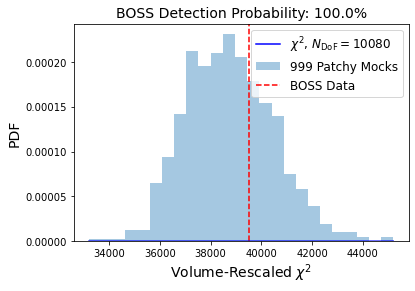

In [156]:
bins = 25
plt.figure()
ct,x,_=plt.hist(opt_chi2,bins=bins,alpha=0.4,density=1,label=r'%d Patchy Mocks'%n_mocks)
x_arr = np.arange(min(x)*1.,max(x)*1.)
p = len(stack_fourpcf_boss)
chi2_pdf = chi2.pdf(x_arr,p)
boss_prob = chi2.cdf(opt_chi2_boss,p)
ymax = max([max(ct),max(chi2_pdf)])*1.05
print("Chi2-BOSS/N_DoF: %.2f"%(opt_chi2_boss/len(stack_fourpcf_boss)))
plt.title(r'BOSS Detection Probability: %.1f%%'%(100.*boss_prob),fontsize=14)
print("Effective sigmas: %.2f"%(np.sqrt(-2.*np.log(1.-boss_prob))))
plt.plot(x_arr,chi2_pdf,color='blue',label=r'$\chi^2$, $N_\mathrm{DoF} = %d$'%p)
plt.vlines(opt_chi2_boss,0,ymax,color='red',linestyles='--',label='BOSS Data')
plt.legend(fontsize=12);
plt.ylim([0,ymax])
plt.xlabel(r'Volume-Rescaled $\chi^2$',fontsize=14)
plt.ylabel(r'PDF',fontsize=14)
plt.savefig(plot_dir+'vol_rescaled_chi2.pdf',bbox_inches='tight')

In [157]:
patch = 'ngc'

### Load rescaled theory covariances
def load_rescaled_theory_cov(patch):
    if patch=='ngc':
        cov_file = '/projects/QUIJOTE/Oliver/npcf/gaussian_cov/4pcf_patchy_ngc_z0d57_connected_nbar8.9E-05_all_fit.cov'
    elif patch=='sgc':
        raise Exception("SGC covariance not found!")
    cov_dat = pickle.load(open(cov_file, "rb"))
    
    # Construct covariance
    theory_cov = np.zeros((n_mult*n_radial,n_mult*n_radial))
    for i in range(n_mult):
        lam1 = '%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i])
        for j in range(n_mult):
            lam2 = '%d%d%d'%(ells[0][ang_filt][j],ells[1][ang_filt][j],ells[2][ang_filt][j])
            try: 
                this_cov = cov_dat[lam1,lam2]
            except KeyError:
                try:
                    this_cov = cov_dat[lam2,lam1].T
                except KeyError:
                    print("Covariance element %s,%s has not been computed!"%(lam1,lam2))
            theory_cov[i*n_radial:(i+1)*n_radial,j*n_radial:(j+1)*n_radial] = this_cov[radial_filt][:,radial_filt]
    return theory_cov

resc_cov = load_rescaled_theory_cov(patch)

Covariance element 011,202 has not been computed!
Covariance element 011,211 has not been computed!
Covariance element 011,213 has not been computed!
Covariance element 011,220 has not been computed!
Covariance element 011,222 has not been computed!
Covariance element 011,224 has not been computed!
Covariance element 011,231 has not been computed!
Covariance element 011,233 has not been computed!
Covariance element 011,242 has not been computed!
Covariance element 011,244 has not been computed!
Covariance element 011,303 has not been computed!
Covariance element 011,312 has not been computed!
Covariance element 011,314 has not been computed!
Covariance element 011,321 has not been computed!
Covariance element 011,323 has not been computed!
Covariance element 011,330 has not been computed!
Covariance element 011,332 has not been computed!
Covariance element 011,334 has not been computed!
Covariance element 011,341 has not been computed!
Covariance element 011,343 has not been computed!


Covariance element 321,242 has not been computed!
Covariance element 321,244 has not been computed!
Covariance element 321,303 has not been computed!
Covariance element 321,312 has not been computed!
Covariance element 321,314 has not been computed!
Covariance element 321,323 has not been computed!
Covariance element 321,330 has not been computed!
Covariance element 321,332 has not been computed!
Covariance element 321,334 has not been computed!
Covariance element 321,341 has not been computed!
Covariance element 321,343 has not been computed!
Covariance element 321,404 has not been computed!
Covariance element 321,413 has not been computed!
Covariance element 321,422 has not been computed!
Covariance element 321,424 has not been computed!
Covariance element 321,431 has not been computed!
Covariance element 321,433 has not been computed!
Covariance element 321,440 has not been computed!
Covariance element 321,442 has not been computed!
Covariance element 321,444 has not been computed!


#### 5b) Repeat for NGC and SGC separately

In [ ]:
### First, stack the N and S data (with independent covariances)
theory_modelN = np.zeros_like(filt_flat_fourpcf_bossN)
theory_modelS = np.zeros_like(filt_flat_fourpcf_bossS)

# Compute an optimal rescaling factor for NGC and SGC separately
trace_disc_0N = np.trace(np.matmul(inv_theory_covN,covN))
logdet0N = np.linalg.slogdet(inv_theory_covN)[1]
def KL_div(rescaling):
    """Use the Kullback-Leibler divergence to give the log-likelihood for the rescaling."""
    return trace_disc_0N/rescaling-(logdet0N-np.log(rescaling)*len(covN))

opt_rescalingN = minimize(KL_div,1.).x
print("Optimal Rescaling: %.2fx"%opt_rescalingN)

trace_disc_0S = np.trace(np.matmul(inv_theory_covS,covS))
logdet0S = np.linalg.slogdet(inv_theory_covS)[1]
def KL_div(rescaling):
    """Use the Kullback-Leibler divergence to give the log-likelihood for the rescaling."""
    return trace_disc_0S/rescaling-(logdet0S-np.log(rescaling)*len(covS))

opt_rescalingS = minimize(KL_div,1.).x
print("Optimal Rescaling: %.2fx"%opt_rescalingS)

# Rescale theory matrix
opt_theory_covN = theory_covN*opt_rescalingN
opt_theory_covS = theory_covS*opt_rescalingS
inv_opt_theory_covN = inv_theory_covN/opt_rescalingN
inv_opt_theory_covS = inv_theory_covS/opt_rescalingS

Optimal Rescaling: 2.05x


In [ ]:
dN = filt_flat_fourpcfN-theory_modelN[None,:]
opt_chi2N = np.sum(dN.T*np.matmul(inv_opt_theory_covN,dN.T),axis=0)
opt_chi2_bossN = np.sum((filt_flat_fourpcf_bossN-theory_modelN)*np.matmul(inv_opt_theory_covN,filt_flat_fourpcf_bossN-theory_modelN))
dS = filt_flat_fourpcfS-theory_modelS[None,:]
opt_chi2S = np.sum(dS.T*np.matmul(inv_opt_theory_covS,dS.T),axis=0)
opt_chi2_bossS = np.sum((filt_flat_fourpcf_bossS-theory_modelS)*np.matmul(inv_opt_theory_covS,filt_flat_fourpcf_bossS-theory_modelS))

In [ ]:
bins = 25
plt.figure()
ct,x,_=plt.hist(opt_chi2N,bins=bins,alpha=0.4,density=1,label=r'%d Patchy Mocks - NGC'%n_mocks,color='r')
ct,x,_=plt.hist(opt_chi2S,bins=bins,alpha=0.4,density=1,label=r'%d Patchy Mocks - SGC'%n_mocks,color='b')
x_arr = np.arange(min(x)*1.,max(x)*1.)
p = len(filt_flat_fourpcfN[0])
chi2_pdf = chi2.pdf(x_arr,p)
boss_probN = chi2.cdf(opt_chi2_bossN,p)
boss_probS = chi2.cdf(opt_chi2_bossS,p)
ymax = max([max(ct),max(chi2_pdf)])*1.05
print("Chi2-BOSS/N_DoF: %.2f (NGC) %.2f (SGC)"%(opt_chi2_bossN/len(filt_flat_fourpcf_bossN),opt_chi2_bossS/len(filt_flat_fourpcf_bossS)))
plt.title(r'BOSS Detection Probability: %.1f%% (NGC) %.1f%% (SGC)'%(100.*boss_probN,100.*boss_probS),fontsize=14)
print("Effective sigmas: %.2f (NGC) %.2f (SGC)"%(np.sqrt(-2.*np.log(1.-boss_probN)),np.sqrt(-2.*np.log(1.-boss_probS))))
plt.plot(x_arr,chi2_pdf,color='orange',label=r'$\chi^2$, $N_\mathrm{DoF} = %d$'%p)
plt.vlines(opt_chi2_bossN,0,ymax,color='r',linestyles='--',label='BOSS Data - NGC')
plt.vlines(opt_chi2_bossS,0,ymax,color='b',linestyles='--',label='BOSS Data - SGC')
plt.legend(fontsize=12);
plt.ylim([0,ymax])
plt.xlabel(r'Volume-Rescaled $\chi^2$',fontsize=14)
plt.ylabel(r'PDF',fontsize=14)
#plt.savefig(plot_dir+'vol_rescaled_chi2.pdf',bbox_inches='tight')

# 6) Perform data compression

- We project the data onto the eigenvectors of the *model* inverse covariance matrix.
- This would be an optimal projection if true = model covariance, in the Gaussian limit.
- Here, $v = U^T\zeta$ where $\tilde{\mathsf C} = U\Lambda U^T$, and we keep the first $N_\mathrm{eig}$ eigenvectors, which are ordered in signal-to-noise, as in Scoccimarro 2000.
- The covariance matrix of $v$ is *close* to diagonal, with $\langle vv^T \rangle = U^TC_DU$. If $C_D = \tilde{\mathsf{C}} = U\Lambda U^T$, then $\langle vv^T \rangle = \Lambda$, which is diagonal.

- This is performed for NGC and SGC independently, since they are assumed to be independent.

In [ ]:
fourpcf_meanN = np.mean(filt_flat_fourpcfN,axis=0)
fourpcf_meanS = np.mean(filt_flat_fourpcfS,axis=0)

# Compute (squared) signal-to-noise of each eigenvector
SN_N = np.matmul(evecsN.T,fourpcf_meanN)**2.*evalsN
SN_S = np.matmul(evecsS.T,fourpcf_meanS)**2.*evalsS

# Cut to first N_eig vectors
orderN = np.argsort(SN_N)[::-1]
orderS = np.argsort(SN_S)[::-1]
evalsN = evalsN[orderN]
evalsS = evalsS[orderS]
evecsN = evecsN[:,orderN]
evecsS = evecsS[:,orderS]

In [ ]:
plt.plot(np.cumsum(SN_N[orderN])/np.sum(SN_N[orderN]))
#plt.yscale('log')
#plt.xlim([0,5000])
#plt.ylim([100,1e4])

In [ ]:
def project_data(data,N_eig,patch='ngc'):
    """Project data onto the eigenvector basis for NGC or SGC. 
    Note that the mean vector cancels in all chi^2-type analyses, but is included by convention."""
    if patch=='ngc':
        these_evecs = evecsN[:,:N_eig]
        mean = fourpcf_meanN
    else:
        these_evecs = evecsS[:,:N_eig]
        mean = fourpcf_meanS
    proj_data = np.matmul(these_evecs.T,(data-mean).T).T
    return proj_data

def deproject_data(projected_data,N_eig,patch='ngc'):
    """Deproject data out of the eigenvector basis."""
    if patch=='ngc':
        these_evecs = evecsN[:,:N_eig]
        mean = fourpcf_meanN
    else:
        these_evecs = evecsS[:,:N_eig]
        mean = fourpcf_meanS
    deproj_data = mean + np.matmul(these_evecs,projected_data.T).T
    return deproj_data

N_eig = 50
projected_fourpcfN = project_data(filt_flat_fourpcfN,N_eig,'ngc')
projected_fourpcfS = project_data(filt_flat_fourpcfS,N_eig,'sgc')
projected_fourpcf_bossN = project_data(filt_flat_fourpcf_bossN,N_eig,'ngc')
projected_fourpcf_bossS = project_data(filt_flat_fourpcf_bossS,N_eig,'sgc')

projected_theoryN = project_data(np.zeros_like(filt_flat_fourpcf_bossN),N_eig,'ngc')
projected_theoryS = project_data(np.zeros_like(filt_flat_fourpcf_bossS),N_eig,'sgc')

In [ ]:
plt.imshow(1e7*np.cov(projected_fourpcfN.T),cmap=cm.RdBu_r,vmax=2,vmin=-2);
fs = 14
cbar = plt.colorbar();
plt.xlabel(r'Eigenvalue Index',fontsize=fs)
plt.ylabel(r'Eigenvalue Index',fontsize=fs)
cbar.set_label(r'$10^5\times$ Projected Covariance',fontsize=fs)
plt.savefig(plot_dir+'projected_4pcf_covN.pdf',bbox_inches='tight')

In [ ]:
meanN = projected_fourpcfN.mean(axis=0)-projected_theoryN
stdN = projected_fourpcfN.std(axis=0)
meanS = projected_fourpcfS.mean(axis=0)-projected_theoryS
stdS = projected_fourpcfS.std(axis=0)
i_arr = np.arange(len(meanN))
plt.errorbar(i_arr,meanN,label='Patchy: NGC',c='b')
plt.errorbar(i_arr,meanS,label='Patchy: SGC',c='r')
plt.errorbar(i_arr,projected_fourpcf_bossN-projected_theoryN,ls='',marker='x',alpha=0.8,
             yerr=stdN,label='BOSS Data',c='b')
plt.errorbar(i_arr,projected_fourpcf_bossS-projected_theoryS,ls='',marker='x',alpha=0.5,
             yerr=stdS,label='BOSS Data',c='r')
plt.fill_between(i_arr,meanN-stdN,meanN+stdN,alpha=0.1,color='b')
plt.fill_between(i_arr,meanS-stdS,meanS+stdS,alpha=0.1,color='r')
plt.xlabel(r'Eigenvalue Index',fontsize=14)
plt.ylabel(r'$\Delta$(Projected 4PCF)',fontsize=14)
plt.xlim([-0.5,N_eig-0.5])
plt.legend(fontsize=12)
vmax = np.max([np.max(projected_fourpcf_bossS-projected_theoryS+stdS),np.max(projected_fourpcf_bossN-projected_theoryN+stdN)])
plt.ylim([-vmax*2,vmax*2])
plt.savefig(plot_dir+'projected_4pcf_data.pdf',bbox_inches='tight')

# 7) Perform a Gaussian hypothesis test for the projected statistic

Given projected data $v$, we can form a Gaussian test statistic:

$$T^2 = v^T\hat{\mathsf{C}}^{-1}v,$$
where $\hat{\mathsf{C}}$ is the sample covariance matrix, and we assume zero sample mean, matching the null hypothesis of no non-Gaussianity. As in Sellentin & Heavens 2016, this follows a modified $F$-distribution, such that
$$T^2\sim \frac{\Gamma\left(\frac{n+1}{2}\right)}{\Gamma(p/2)\Gamma[(n-p+1)/2]}\frac{n^{-p/2}(T^2)^{p/2-1}}{(T^2/n+1)^{(n+1)/2}}$$
where $p = \mathrm{dim}(v)$ and $n = N_\mathrm{mocks}-1$.

We can also form the conventional $\chi^2$ statistic, including the Hartlap factor required to debias noisy inverse covariance matrices:
$$H^2 = f_H\times v^T\hat{\mathsf{C}}^{-1}v,$$ where $f_H = (n-p-1)/n$. This is usually assumed to follow $\chi^2$ statistics, *i.e.* $H^2\sim \chi^2_p$, but this breaks down at small $n$.

Here, we consider both distributions. To form a distribution of sample data, we use a bootstrap method, computing the covariance from $(N-1)$ mocks and repeating, to ensure independence.

We repeat the analysis for several choices of $N_\mathrm{eig}$, and combine the NGC and SGC measurements (by convolving two PDFs), assuming independence.

In [ ]:
N_eigs = [10,50,100,250]

fig1,ax1 = plt.subplots(1,len(N_eigs),figsize=(5*len(N_eigs),4))
fig2,ax2 = plt.subplots(1,len(N_eigs),figsize=(5*len(N_eigs),4))

for nn,N_eig in enumerate(N_eigs):
    print("\n\nN_eig = %d"%N_eig)
    projected_fourpcfN = project_data(filt_flat_fourpcfN,N_eig,'ngc')
    projected_fourpcfS = project_data(filt_flat_fourpcfS,N_eig,'sgc')
    projected_fourpcf_bossN = project_data(filt_flat_fourpcf_bossN,N_eig,'ngc')
    projected_fourpcf_bossS = project_data(filt_flat_fourpcf_bossS,N_eig,'sgc')

    projected_theoryN = project_data(np.zeros_like(filt_flat_fourpcf_bossN),N_eig,'ngc')
    projected_theoryS = project_data(np.zeros_like(filt_flat_fourpcf_bossS),N_eig,'sgc')
    
    ### Compute distribution of mock data using sets of (N-1) mocks
    this_n_mocks = len(projected_fourpcfN)-1

    all_T2, all_H2 = [],[]
    for i in range(len(projected_fourpcfN)):

        # Define data
        projected_mockN = projected_fourpcfN[i]
        projected_mockS = projected_fourpcfS[i]

        # Define sample covariance in projected space
        projected_covN = np.cov(projected_fourpcfN[np.arange(len(projected_fourpcfN))!=i].T)
        projected_covS = np.cov(projected_fourpcfS[np.arange(len(projected_fourpcfS))!=i].T)
        
        inv_projected_covN = np.linalg.inv(projected_covN)
        inv_projected_covS = np.linalg.inv(projected_covS)

        T2_statistic = np.inner(projected_mockN-projected_theoryN,np.inner(inv_projected_covN,projected_mockN-projected_theoryN))
        T2_statistic += np.inner(projected_mockS-projected_theoryS,np.inner(inv_projected_covS,projected_mockS-projected_theoryS))
        
        all_T2.append(T2_statistic)
        
    all_T2 = np.asarray(all_T2)
    
    # Compute also Hartlap-rescaled statistic
    hartlap_factor = (this_n_mocks-N_eig-2.)/(this_n_mocks-1)
    print("Hartlap Factor for Bootstrapped PDF: %.3f"%hartlap_factor)
    all_H2 = all_T2*hartlap_factor
    
    ### Compute T2 and H2 statistics on BOSS data using all N_mocks mocks
    projected_covN = np.cov(projected_fourpcfN.T)
    projected_covS = np.cov(projected_fourpcfS.T)
    inv_projected_covN = np.linalg.inv(projected_covN)
    inv_projected_covS = np.linalg.inv(projected_covS)
    T2_boss = np.inner(projected_fourpcf_bossN-projected_theoryN,np.inner(inv_projected_covN,projected_fourpcf_bossN-projected_theoryN))
    T2_boss += np.inner(projected_fourpcf_bossS-projected_theoryS,np.inner(inv_projected_covS,projected_fourpcf_bossS-projected_theoryS))
    hartlap_factor = (n_mocks-N_eig-2.)/(n_mocks-1)
    print("Hartlap Factor for BOSS: %.3f"%hartlap_factor)
    H2_boss = T2_boss*hartlap_factor
    
    ### Compute PDFs and CDFs (easiest to do CDFs numerically with a fine grid)
    mmax = max(all_T2)*1.2
    x_arr = np.linspace(0.001,mmax,10000)
    p = N_eig
    n = n_mocks-1
    chi2_single_pdf = chi2.pdf(x_arr,p)
    T2_single_pdf = np.exp((p/2.-1.)*np.log(x_arr)-p/2.*np.log(n)-0.5*(n+1.)*np.log(x_arr/n+1.))*np.exp(loggamma((n+1.)/2.)-loggamma(p/2.)-loggamma((n-p+1.)/2.))

    # Compute PDF of H^2_NGC + H^2_SGC using a convolution
    chi2_pdf = np.fft.ifft(np.fft.fft(chi2_single_pdf)**2.).real
    chi2_pdf /= np.sum(chi2_pdf)*np.diff(x_arr)[0]
    
    # Compute PDF of T^2_NGC + T^2_SGC using a convolution
    T2_pdf = np.fft.ifft(np.fft.fft(T2_single_pdf)**2.).real
    T2_pdf /= np.sum(T2_pdf)*np.diff(x_arr)[0]
    
    # Compute CDFs
    chi2_cdf = interp1d(x_arr,np.cumsum(chi2_pdf)*np.diff(x_arr)[0])
    T2_cdf = interp1d(x_arr,np.cumsum(T2_pdf)*np.diff(x_arr)[0])

    ### Plot distributions
    # Ideally: T^2 statistic should follow the T^2 curve, whilst H^2 statistic is slightly more peaked than the chi^2 curve 

    bins = 25
    #plt.figure()
    ct,_,_=ax1[nn].hist(all_H2,bins=bins,alpha=0.4,density=1,color='orange')#,label=r'$H^2$')
    ax1[nn].hist(all_T2,bins=bins,alpha=0.4,density=1,color='blue')#,label=r'$T^2$');
    ax1[nn].vlines(T2_boss,0,2*mmax,color='blue',linestyles='--')
    ax1[nn].vlines(H2_boss,0,2*mmax,color='orange',linestyles='--')
    ax1[nn].plot(x_arr,chi2_pdf,color='orange',label=r'$H^2$')
    ax1[nn].plot(x_arr,T2_pdf,color='blue',label=r'$T^2$')
    if nn==0:
        ax1[nn].legend(fontsize=12);
    ax1[nn].set_xlim([0,mmax])
    ax1[nn].set_ylim([0,max([max(ct),max(chi2_pdf)])*1.05])
    ax1[nn].set_xlabel(r'$H^2$ or $T^2$',fontsize=14)
    if nn==0: ax1[nn].set_ylabel(r'PDF',fontsize=14)
    ax1[nn].set_title(r'$N_\mathrm{eig} = %d$'%N_eig,fontsize=14);
    if nn==2: fig1.savefig(plot_dir+'projected_pdfs_all.pdf',bbox_inches='tight')

    ### Compute detection probabilities, as a 1-tail test
    prob_T2 = T2_cdf(all_T2)
    prob_chi2 = chi2_cdf(all_H2)

    prob_T2_boss = T2_cdf(T2_boss)
    prob_chi2_boss = chi2_cdf(H2_boss)

    # Count fraction of false detections 
    N_detections_T2 = (np.sum(prob_T2>0.95))*1./n_mocks
    N_detections_chi2 = (np.sum(prob_chi2>0.95))*1./n_mocks

    print("\nFraction of 2-sigma detections with %d eigenvalues"%N_eig)
    print("chi^2 + Hartlap model: %.3f"%N_detections_chi2)
    print("T^2: %.3f"%N_detections_T2)
    print("Expected: %.3f"%(0.05))

    print("\nBOSS Detection Rates:")
    print("chi^2 + Hartlap model: %.3f"%prob_chi2_boss)
    print("T^2: %.3f"%prob_T2_boss)
    print("Effective Sigmas: %.2f"%np.sqrt(-2.*np.log(1.-prob_chi2_boss)))

    ### Histogram the detection PDFs
    ax2[nn].set_title(r'BOSS: %.1f%%'%(100.*prob_T2_boss),fontsize=14)
    ct,_,_=ax2[nn].hist(prob_chi2,bins=bins,histtype='step',color='orange',label=r'$H^2$',density=0,range=[0,1]);
    ax2[nn].hist(prob_T2,bins=bins,histtype='step',color='blue',label=r'$T^2$',density=0,range=[0,1]);
    ax2[nn].hlines(n_mocks/bins,0,1,linestyles='--')
    ax2[nn].vlines(prob_chi2_boss,0,max(ct)*1.2,color='orange',linestyles='--')
    ax2[nn].vlines(prob_T2_boss,0,max(ct)*1.2,color='blue',linestyles='--')
    ax2[nn].set_xlim([0.0,1])
    ax2[nn].fill_betweenx(np.arange(0,max(ct)*2),0.95,1,alpha=0.1,color='k')
    ax2[nn].set_ylim([0,max(ct)*1.1])
    if nn==0: ax2[nn].legend(fontsize=12,loc='lower right');
    if nn==0: ax2[nn].set_ylabel(r'Occurences',fontsize=14)
    ax2[nn].set_xlabel(r'Detection Probability',fontsize=14);
    if nn==2:
        fig2.savefig(plot_dir+'projected_cdfs_all.pdf',bbox_inches='tight')

### 7b) Repeat for NGC and SGC separately

In [ ]:
N_eigs = [10,50,100,250]

fig1,ax1 = plt.subplots(1,len(N_eigs),figsize=(5*len(N_eigs),4))
fig2,ax2 = plt.subplots(1,len(N_eigs),figsize=(5*len(N_eigs),4))

for nn,N_eig in enumerate(N_eigs):

    print("N_eig = %d"%N_eig)
    projected_fourpcfN = project_data(filt_flat_fourpcfN,N_eig,'ngc')
    projected_fourpcfS = project_data(filt_flat_fourpcfS,N_eig,'sgc')
    projected_fourpcf_bossN = project_data(filt_flat_fourpcf_bossN,N_eig,'ngc')
    projected_fourpcf_bossS = project_data(filt_flat_fourpcf_bossS,N_eig,'sgc')

    projected_theoryN = project_data(np.zeros_like(filt_flat_fourpcf_bossN),N_eig,'ngc')
    projected_theoryS = project_data(np.zeros_like(filt_flat_fourpcf_bossS),N_eig,'sgc')

    ### Compute distribution of mock data using sets of (N-1) mocks
    this_n_mocks = len(projected_fourpcfN)-1

    all_T2N, all_H2N, all_T2S, all_H2S = [],[],[],[]
    for i in range(len(projected_fourpcfN)):

        # Define data
        projected_mockN = projected_fourpcfN[i]
        projected_mockS = projected_fourpcfS[i]

        # Define sample covariance in projected space
        projected_covN = np.cov(projected_fourpcfN[np.arange(len(projected_fourpcfN))!=i].T)
        projected_covS = np.cov(projected_fourpcfS[np.arange(len(projected_fourpcfS))!=i].T)

        inv_projected_covN = np.linalg.inv(projected_covN)
        inv_projected_covS = np.linalg.inv(projected_covS)

        T2_statisticN = np.inner(projected_mockN-projected_theoryN,np.inner(inv_projected_covN,projected_mockN-projected_theoryN))
        T2_statisticS = np.inner(projected_mockS-projected_theoryS,np.inner(inv_projected_covS,projected_mockS-projected_theoryS))

        all_T2N.append(T2_statisticN)
        all_T2S.append(T2_statisticS)

    all_T2N = np.asarray(all_T2N)
    all_T2S = np.asarray(all_T2S)

    # Compute also Hartlap-rescaled statistic
    hartlap_factor = (this_n_mocks-N_eig-2.)/(this_n_mocks-1)
    print("Hartlap Factor for Bootstrapped PDF: %.3f"%hartlap_factor)
    all_H2N = all_T2N*hartlap_factor
    all_H2S = all_T2S*hartlap_factor

    ### Compute T2 and H2 statistics on BOSS data using all N_mocks mocks
    projected_covN = np.cov(projected_fourpcfN.T)
    projected_covS = np.cov(projected_fourpcfS.T)
    inv_projected_covN = np.linalg.inv(projected_covN)
    inv_projected_covS = np.linalg.inv(projected_covS)
    T2_bossN = np.inner(projected_fourpcf_bossN-projected_theoryN,np.inner(inv_projected_covN,projected_fourpcf_bossN-projected_theoryN))
    T2_bossS = np.inner(projected_fourpcf_bossS-projected_theoryS,np.inner(inv_projected_covS,projected_fourpcf_bossS-projected_theoryS))
    hartlap_factor = (n_mocks-N_eig-2.)/(n_mocks-1)
    print("Hartlap Factor for BOSS: %.3f"%hartlap_factor)
    H2_bossN = T2_bossN*hartlap_factor
    H2_bossS = T2_bossS*hartlap_factor

    ### Compute PDFs and CDFs (easiest to do CDFs numerically with a fine grid)
    mmax = max(all_T2N)*1.2
    x_arr = np.linspace(0.001,mmax,10000)
    p = N_eig
    n = n_mocks-1
    chi2_pdf = chi2.pdf(x_arr,p)
    T2_pdf = np.exp((p/2.-1.)*np.log(x_arr)-p/2.*np.log(n)-0.5*(n+1.)*np.log(x_arr/n+1.))*np.exp(loggamma((n+1.)/2.)-loggamma(p/2.)-loggamma((n-p+1.)/2.))

    # Compute CDFs
    chi2_cdf = interp1d(x_arr,np.cumsum(chi2_pdf)*np.diff(x_arr)[0])
    T2_cdf = interp1d(x_arr,np.cumsum(T2_pdf)*np.diff(x_arr)[0])

    bins = 25

    ct,_,_=ax1[nn].hist(all_H2N,bins=bins,alpha=0.4,density=1,color='yellow')#,label=r'$H^2$')
    ct,_,_=ax1[nn].hist(all_H2S,bins=bins,alpha=0.4,density=1,color='red')#,label=r'$H^2$')
    ax1[nn].hist(all_T2N,bins=bins,alpha=0.4,density=1,color='aquamarine')#,label=r'$T^2$');
    ax1[nn].hist(all_T2S,bins=bins,alpha=0.4,density=1,color='green')#,label=r'$T^2$');
    ax1[nn].vlines(H2_bossN,0,2*mmax,color='yellow',linestyles='--')
    ax1[nn].vlines(H2_bossS,0,2*mmax,color='red',linestyles='--')
    ax1[nn].vlines(T2_bossN,0,2*mmax,color='aquamarine',linestyles='--')
    ax1[nn].vlines(T2_bossS,0,2*mmax,color='green',linestyles='--')
    ax1[nn].plot(x_arr,chi2_pdf,color='orange',label=r'$H^2$')
    ax1[nn].plot(x_arr,T2_pdf,color='blue',label=r'$T^2$')
    if nn==0:
        ax1[nn].legend(fontsize=12);
    ax1[nn].set_xlim([0,mmax])
    ax1[nn].set_ylim([0,max([max(ct),max(chi2_pdf)])*1.05])
    ax1[nn].set_xlabel(r'$H^2$ or $T^2$',fontsize=14)
    if nn==0: ax1[nn].set_ylabel(r'PDF',fontsize=14)
    ax1[nn].set_title(r'$N_\mathrm{eig} = %d$'%N_eig,fontsize=14);
    if nn==2: fig1.savefig(plot_dir+'projected_pdfs_ngc_sgc_all.pdf',bbox_inches='tight')

    ### Compute detection probabilities, as a 1-tail test
    prob_T2N = T2_cdf(all_T2N)
    prob_T2S = T2_cdf(all_T2S)
    prob_chi2N = chi2_cdf(all_H2N)
    prob_chi2S = chi2_cdf(all_H2S)

    prob_T2_bossN = T2_cdf(T2_bossN)
    prob_T2_bossS = T2_cdf(T2_bossS)
    prob_chi2_bossN = chi2_cdf(H2_bossN)
    prob_chi2_bossS = chi2_cdf(H2_bossS)

    # Count fraction of false detections 
    N_detections_T2N = (np.sum(prob_T2N>0.95))*1./n_mocks
    N_detections_T2S = (np.sum(prob_T2S>0.95))*1./n_mocks
    N_detections_chi2N = (np.sum(prob_chi2N>0.95))*1./n_mocks
    N_detections_chi2S = (np.sum(prob_chi2S>0.95))*1./n_mocks

    print("\nFraction of 2-sigma detections with %d eigenvalues"%N_eig)
    print("chi^2 + Hartlap model: %.3f / %.3f"%(N_detections_chi2N,N_detections_chi2S))
    print("T^2: %.3f / %.3f"%(N_detections_T2N,N_detections_T2S))
    print("Expected: %.3f"%(0.05))

    print("\nBOSS Detection Rates:")
    print("chi^2 + Hartlap model: %.3f / %.3f"%(prob_chi2_bossN,prob_chi2_bossS))
    print("T^2: %.3f / %.3f"%(prob_T2_bossN,prob_T2_bossS))
    print("Effective sigmas: %.2f / %.2f\n"%(np.sqrt(-2.*np.log(1.-prob_chi2_bossN)),np.sqrt(-2.*np.log(1.-prob_chi2_bossS))))


    ### Histogram the detection PDFs
    ax2[nn].set_title(r'BOSS: %.1f%% / %.1f%%'%(100.*prob_T2_bossN,100.*prob_T2_bossS),fontsize=14)
    ct,_,_=ax2[nn].hist(prob_chi2N,bins=bins,histtype='step',color='yellow',density=0,range=[0,1]);
    ct,_,_=ax2[nn].hist(prob_chi2S,bins=bins,histtype='step',color='red',label=r'$H^2$',density=0,range=[0,1]);
    ax2[nn].hist(prob_T2N,bins=bins,histtype='step',color='aquamarine',density=0,range=[0,1]);
    ax2[nn].hist(prob_T2S,bins=bins,histtype='step',color='green',label=r'$T^2$',density=0,range=[0,1]);
    ax2[nn].hlines(n_mocks/bins,0,1,linestyles='--')
    ax2[nn].vlines(prob_chi2_bossN,0,max(ct)*1.2,color='yellow',linestyles='--')
    ax2[nn].vlines(prob_chi2_bossS,0,max(ct)*1.2,color='red',linestyles='--')
    ax2[nn].vlines(prob_T2_bossN,0,max(ct)*1.2,color='aquamarine',linestyles='--')
    ax2[nn].vlines(prob_T2_bossS,0,max(ct)*1.2,color='green',linestyles='--')
    ax2[nn].set_xlim([0.0,1])
    ax2[nn].fill_betweenx(np.arange(0,max(ct)*2),0.95,1,alpha=0.1,color='k')
    ax2[nn].set_ylim([0,max(ct)*1.1])
    if nn==0: ax2[nn].legend(fontsize=12,loc='lower right');
    if nn==0: ax2[nn].set_ylabel(r'Occurences',fontsize=14)
    ax2[nn].set_xlabel(r'Detection Probability',fontsize=14);
    if nn==2: fig2.savefig(plot_dir+'projected_cdfs_ngc_sgc_all.pdf',bbox_inches='tight')

### This completes the analysis